**TASK 1 - ANALYSIS**


################## ANIME.CSV ANALYSIS ################## 

Number of columns in anime.csv:  7
Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

Number of rows in anime.csv:  12294

Number of duplicate anime_id in anime.csv:  0

Number of unique genre: 43
Unique genre: ['Drama' 'Romance' 'School' 'Supernatural' 'Action' 'Adventure' 'Fantasy'
 'Magic' 'Military' 'Shounen' 'Comedy' 'Historical' 'Parody' 'Samurai'
 'Sci-Fi' 'Thriller' 'Sports' 'Super Power' 'Space' 'Slice of Life'
 'Mecha' 'Music' 'Mystery' 'Seinen' 'Martial Arts' 'Vampire' 'Shoujo'
 'Horror' 'Police' 'Psychological' 'Demons' 'Ecchi' 'Josei' 'Shounen Ai'
 'Game' 'Dementia' 'Harem' 'Cars' 'Kids' 'Shoujo Ai' 'Hentai' 'Yaoi'
 'Yuri']

Number of unique type: 6
Unique type: ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']

Number of rows with missing values in anime.csv:  277

Rows with missing values in anime.csv:
       anime_id                                       name genre     type

/var/folders/cp/qnxjs_1j4t16tppddxshp8b80000gn/T/ipykernel_47127/3983638592.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


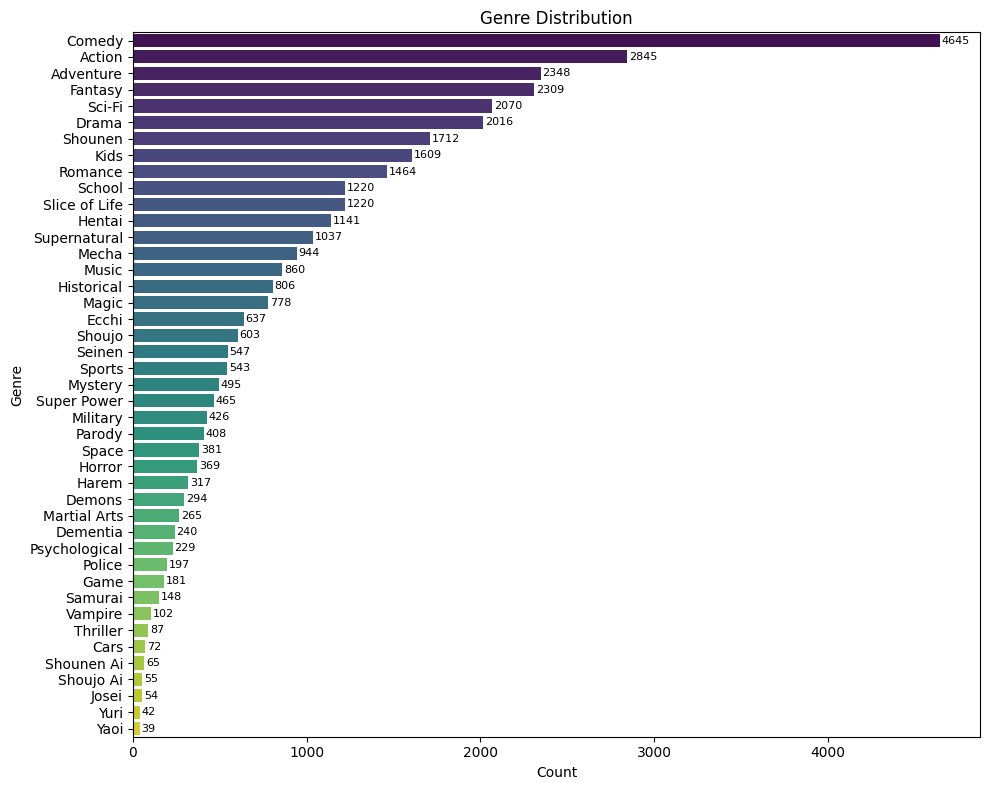

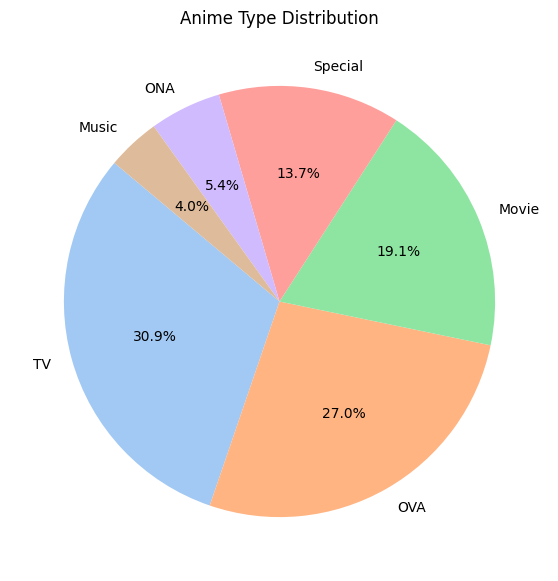

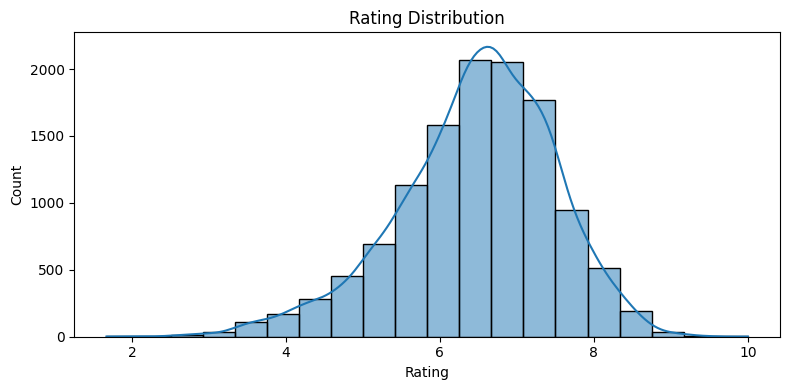


Outliers in 'rating' using IQR method: 229

Outliers in 'episodes' using IQR method: 1123

Outliers in 'members' using IQR method: 1900


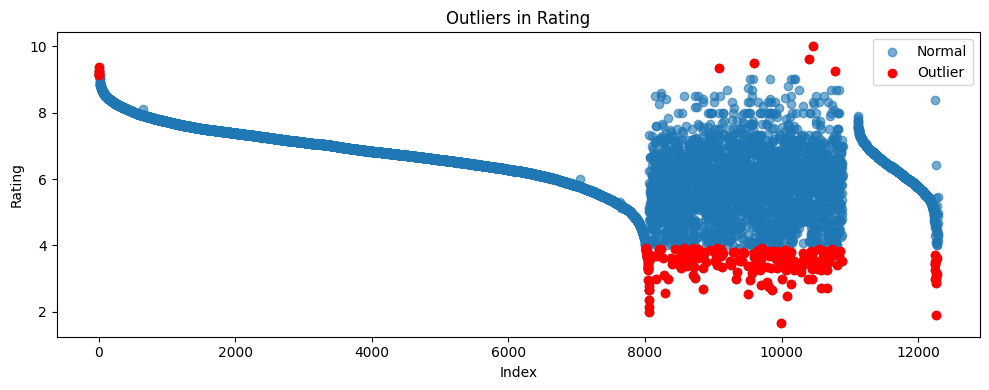

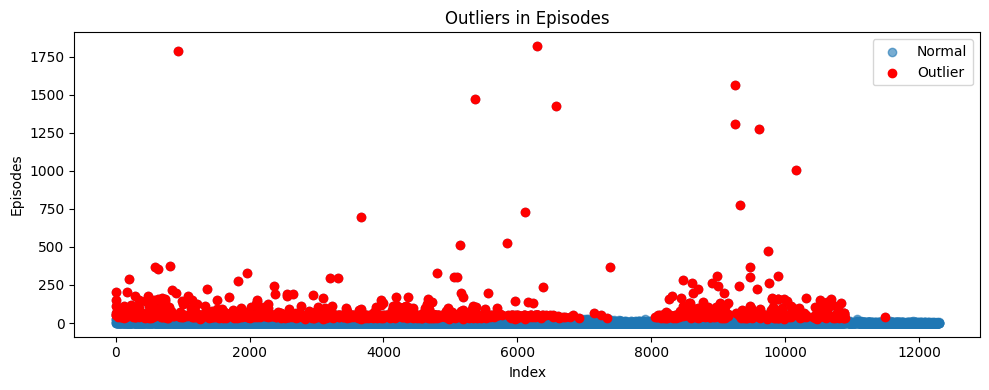

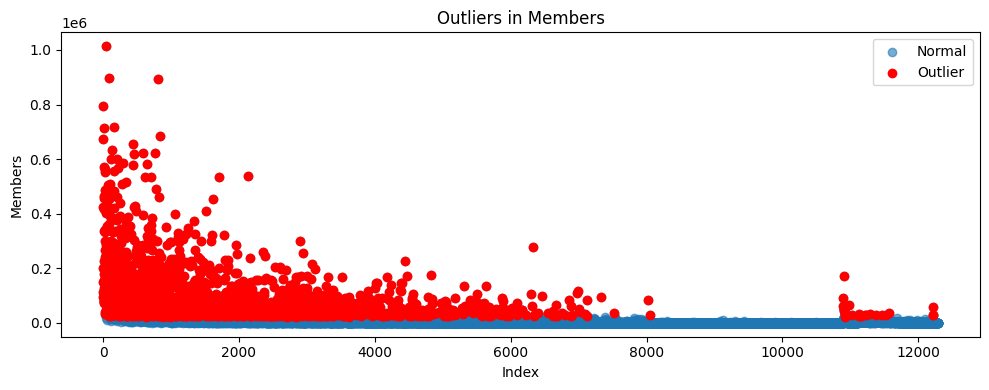

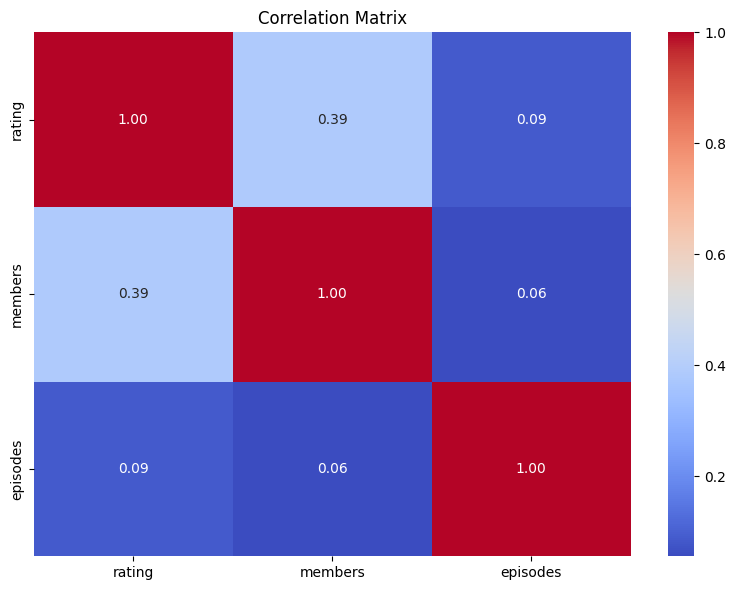


################## RATING.CSV ANALYSIS ################## 

Number of columns in rating.csv:  3
Index(['user_id', 'anime_id', 'rating'], dtype='object')

Number of rows in rating.csv:  7813737

Number of duplicate anime_id in rating.csv:  7802537

Number of unique users in rating.csv:  73515

Number of rows with missing values in rating.csv:  0

Number of rows with -1 as rating in rating.csv:  1476496

Standard descriptive statistics for rating.csv:
             user_id      anime_id        rating
count  7.813737e+06  7.813737e+06  7.813737e+06
mean   3.672796e+04  8.909072e+03  6.144030e+00
std    2.099795e+04  8.883950e+03  3.727800e+00
min    1.000000e+00  1.000000e+00 -1.000000e+00
25%    1.897400e+04  1.240000e+03  6.000000e+00
50%    3.679100e+04  6.213000e+03  7.000000e+00
75%    5.475700e+04  1.409300e+04  9.000000e+00
max    7.351600e+04  3.451900e+04  1.000000e+01


/var/folders/cp/qnxjs_1j4t16tppddxshp8b80000gn/T/ipykernel_47127/3983638592.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=rating_df['rating'], palette='viridis')


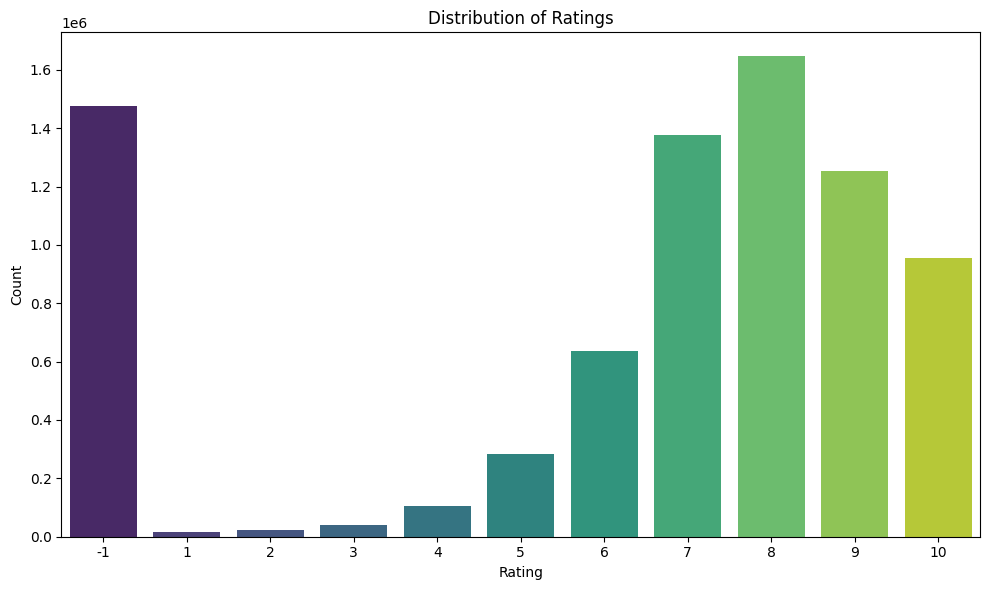

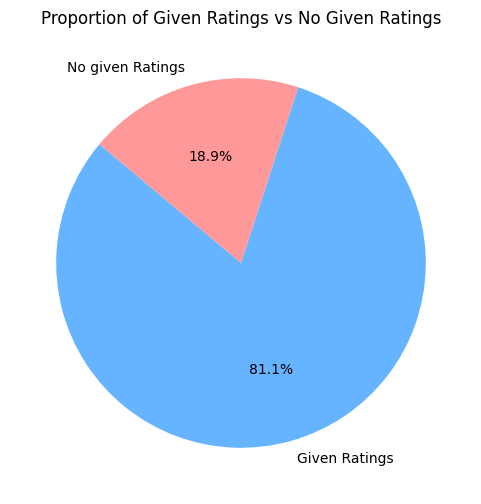


Outliers in 'rating' using IQR method: 1493145


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


############### Helper functions ###############

def count_unique_elements(df: pd.DataFrame, col: str):
    col_series = df[col].dropna()
    all_different_value_col = col_series.str.split(',').explode().str.strip() # Split each genre string by comma and flatten the list
    unique_value_col = all_different_value_col.unique()
    print(f"\nNumber of unique {col}:", len(unique_value_col))
    print(f"Unique {col}:", unique_value_col)
    return unique_value_col, len(unique_value_col)

def detect_outliers_iqr(df: pd.DataFrame, column: str):
    data = df[column].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\nOutliers in '{column}' using IQR method: {len(outliers)}")
    return outliers

def plot_outliers(df: pd.DataFrame, column: str, outliers: pd.DataFrame):
    plt.figure(figsize=(10, 4))
    plt.scatter(df.index, df[column], label='Normal', alpha=0.6)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outlier')
    plt.xlabel('Index')
    plt.ylabel(column.capitalize())
    plt.title(f"Outliers in {column.capitalize()}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'images/outliers_{column}_scatter.png')
    plt.show()

######################################################################
############### TASK 1 (Explore and describe the data) ###############
######################################################################
 
# --------- Analyze anime.csv --------- 

print("################## ANIME.CSV ANALYSIS ################## ")
# 1. Load the dataset
anime_df = pd.read_csv('data/anime.csv')
# 2. Basic checks
print("\nNumber of columns in anime.csv: ", len(anime_df.columns))
print(anime_df.columns)
print("\nNumber of rows in anime.csv: ", len(anime_df))
# check if anime_id contains duplicates
anime_id_duplicates = anime_df['anime_id'].duplicated().sum()
print("\nNumber of duplicate anime_id in anime.csv: ", anime_id_duplicates)
# check unique genres
unique_genres, unique_genres_count = count_unique_elements(anime_df, 'genre')
# check unique type
unique_type, unique_type_count = count_unique_elements(anime_df, 'type')
# check rows that contain missing values, if same row has multiple missing values count only once
missing_values = anime_df.isnull().sum(axis=1) > 0
missing_values_count = missing_values.sum()
print("\nNumber of rows with missing values in anime.csv: ", missing_values_count)
print("\nRows with missing values in anime.csv:\n", anime_df[missing_values].head(5))
# check col with most missing values
missing_values_count = anime_df.isnull().sum()
missing_values_count = missing_values_count[missing_values_count > 0]
missing_values_count = missing_values_count.sort_values(ascending=False)
print("\nColumns with missing values in anime.csv:\n", missing_values_count)
# check cols with 'Unknown' as value
unknown_values_count = anime_df.isin(['Unknown']).sum()
unknown_values_count = unknown_values_count[unknown_values_count > 0]
unknown_values_count = unknown_values_count.sort_values(ascending=False)
print("\nColumns with 'Unknown' as value in anime.csv:\n", unknown_values_count)
# check anime with most episodes, ignore the ones with 'Unknown' as value
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
most_episodes = anime_df[anime_df['episodes'] != 'Unknown'].sort_values(by='episodes', ascending=False).head(3)
print("\nTop 3 anime with most episodes:\n", most_episodes)
# chec anime with least episodes, ignore the ones with 'Unknwon' as value and 1 episode (film)
least_episodes = anime_df[anime_df['episodes'] != 'Unknown']
least_episodes = least_episodes[least_episodes['episodes'] != 1]
least_episodes = least_episodes.sort_values(by='episodes', ascending=True).head(3)
print("\nTop 3 anime with least episodes:\n", least_episodes)
# check anime with most members
anime_df['members'] = pd.to_numeric(anime_df['members'], errors='coerce')
most_members = anime_df.sort_values(by='members', ascending=False).head(3)
print("\nTop 3 anime with most members:\n", most_members)
# check anime with least members
least_members = anime_df[anime_df['members'] != 'Unknown']
least_members = least_members[least_members['members'] != 0]
least_members = least_members.sort_values(by='members', ascending=True).head(3)
print("\nTop 3 anime with least members:\n", least_members)
# check anime with highest rating
anime_df['rating'] = pd.to_numeric(anime_df['rating'], errors='coerce')
highest_rating = anime_df.sort_values(by='rating', ascending=False).head(3)
print("\nTop 3 anime with highest rating:\n", highest_rating)
# check anime with lowest rating
lowest_rating = anime_df[anime_df['rating'] != 0]
lowest_rating = lowest_rating.sort_values(by='rating', ascending=True).head(3)
print("\nTop 3 anime with lowest rating:\n", lowest_rating)
# 3. Standard descriptive statistics
print("\nStandard descriptive statistics for anime.csv:\n", anime_df.describe())
# 4. Variable visualization
# Genre distribution
genre_counts = anime_df['genre'].str.split(',').explode().str.strip().value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(
    y=genre_counts.index,
    x=genre_counts.values,
    palette='viridis'
)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Genre Distribution')
for i, v in enumerate(genre_counts.values):
    plt.text(v + 10, i, str(v), color='black', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('images/genre_distribution_improved.png')
plt.show()
# Type distribution
type_counts = anime_df['type'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
plt.title('Anime Type Distribution')
plt.savefig('images/type_distribution_improved.png')
plt.show()
# Rating distribution
plt.figure(figsize=(8, 4))
sns.histplot(anime_df['rating'].dropna(), bins=20, kde=True)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.tight_layout()
plt.savefig('images/rating_distribution_1.png')
plt.show()

# 5. Outliers
# Detect outliers
rating_outliers = detect_outliers_iqr(anime_df, 'rating')
episode_outliers = detect_outliers_iqr(anime_df, 'episodes')
members_outliers = detect_outliers_iqr(anime_df, 'members')
# Plot outliers
plot_outliers(anime_df, 'rating', rating_outliers)
plot_outliers(anime_df, 'episodes', episode_outliers)
plot_outliers(anime_df, 'members', members_outliers)

# 6. Correlation matrix
correlation_matrix = anime_df[['rating', 'members', 'episodes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('images/correlation_matrix.png')
plt.show()


# --------- Analyze rating.csv --------- 

print("\n################## RATING.CSV ANALYSIS ################## ")
# 1. Load the dataset
rating_df = pd.read_csv('data/rating.csv') 
# 2. Basic checks
print("\nNumber of columns in rating.csv: ", len(rating_df.columns))
print(rating_df.columns)
print("\nNumber of rows in rating.csv: ", len(rating_df))
# check if anime_id contains duplicates
rating_anime_id_duplicates = rating_df['anime_id'].duplicated().sum()
print("\nNumber of duplicate anime_id in rating.csv: ", rating_anime_id_duplicates)
#  check unique users 
unique_userd = rating_df['user_id'].nunique()
print("\nNumber of unique users in rating.csv: ", unique_userd)
# check rows that contain missing values, if same row has multiple missing values count only once
missing_values = rating_df.isnull().sum(axis=1) > 0
missing_values_count = missing_values.sum()
print("\nNumber of rows with missing values in rating.csv: ", missing_values_count)
# check number of rows with -1 as rating
rating_df['rating'] = pd.to_numeric(rating_df['rating'], errors='coerce')
rating_minus_1 = rating_df[rating_df['rating'] == -1]
rating_minus_1_count = rating_minus_1.shape[0]
print("\nNumber of rows with -1 as rating in rating.csv: ", rating_minus_1_count)
# 3. Standard descriptive statistics
print("\nStandard descriptive statistics for rating.csv:\n", rating_df.describe())
# 4. Variable visualization
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=rating_df['rating'], palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/rating_distribution.png')
plt.show()

# Proportion of valid ratings vs -1 ratings
total = len(rating_df)
minus_1 = rating_minus_1_count
valid = total - minus_1

plt.figure(figsize=(6, 6))
plt.pie(
    [valid, minus_1],
    labels=['Given Ratings', 'No given Ratings'],
    autopct='%1.1f%%',
    colors=['#66b3ff', '#ff9999'],
    startangle=140
)
plt.title('Proportion of Given Ratings vs No Given Ratings')
plt.savefig('images/valid_vs_minus1_ratings.png')
plt.show()

# 5. Outliers
# Detect outliers
rating_outliers = detect_outliers_iqr(rating_df, 'rating')

**TASK 2 - PREPROCESSING**

In [2]:
######################################################################
############### TASK 2 (Preprocessing) ###############
######################################################################
# --------- Preprocess anime.csv ---------
def preprocessing(anime_df: pd.DataFrame, rating_df: pd.DataFrame):
    print("\n################## ANIME.CSV PREPROCESSING ################## ")

    # 1. Handle 'episodes'
    anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
    print("\nMissing values in 'episodes' before filling:")
    print(anime_df['episodes'].isnull().sum())
    median_episodes = anime_df['episodes'].median()
    print(f"Median episodes: {median_episodes}")
    anime_df.fillna({'episodes': median_episodes}, inplace=True) # Fill NaN values with median
    print("Missing values in 'episodes' after filling:")
    print(anime_df['episodes'].isnull().sum())

    # 2. Handle 'genre'
    print("\nMissing values in 'genre' before filling:")
    print(anime_df['genre'].isnull().sum())
    anime_df.fillna({'genre': 'Unknown'}, inplace=True) # Fill NaN values with 'Unknown'
    anime_df['genre'] = anime_df['genre'].str.split(', ')
    anime_df['genre'] = anime_df['genre'].apply(lambda x: [i.strip() for i in x]) # Strip whitespace from each genre
    print("Missing values in 'genre' after filling:")
    print(anime_df['genre'].isnull().sum())

    # 3. Handle 'type'
    print("\nMissing values in 'type' before filling:")
    print(anime_df['type'].isnull().sum())
    mode_type = anime_df['type'].mode()[0]
    print(f"Mode type: {mode_type}")
    anime_df.fillna({'type': mode_type}, inplace=True) # Fill NaN values with mode
    print("Missing values in 'type' after filling:")
    print(anime_df['type'].isnull().sum())

    # Handle 'rating'
    print("\nMissing values in 'rating' before filling:")
    print(anime_df['rating'].isnull().sum())
    mean_rating = anime_df['rating'].mean()
    print(f"Mean rating: {mean_rating}")
    anime_df.fillna({'rating': mean_rating}, inplace=True) # Fill NaN values with mean
    print("Missing values in 'rating' after filling:")
    print(anime_df['rating'].isnull().sum())

    # --- Preprocess rating.csv ---
    print("\n################## RATING.CSV PREPROCESSING ################## ")
    # Handle -1 as missing ratings
    rating_df.replace({-1: np.nan}, inplace=True)
    # drop rows with NaN ratings
    print("\nMissing values in 'rating' before dropping:")
    print(rating_df['rating'].isnull().sum())
    rating_df.dropna(subset=['rating'], inplace=True)
    print("Missing values in 'rating' after dropping:")
    print(rating_df['rating'].isnull().sum())

    # Drop duplicate ratings if any
    # Count and show duplicated ratings
    duplicates = rating_df[rating_df.duplicated(subset=['user_id', 'anime_id'], keep=False)]
    duplicate_counts = duplicates.groupby(['user_id', 'anime_id']).size().reset_index(name='count')
    duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

    print("\nNumber of duplicate ratings before dropping:", len(duplicates) // 2)
    print("Duplicate rows and their counts:")
    print(duplicate_counts)
    rating_df.drop_duplicates(subset=['user_id', 'anime_id'], inplace=True)
    print("Rating length after dropping duplicates:", len(rating_df))

    return anime_df, rating_df

# Recommendation system

In [3]:
# Load and preprocess
anime_df = pd.read_csv('data/anime.csv')
rating_df = pd.read_csv('data/rating.csv')
anime_df, rating_df = preprocessing(anime_df, rating_df)

print("\n################## TASK 3: COLLABORATIVE FILTERING ################## ")
# -------------------- Prepare Data --------------------
# Convert user_id and anime_id to categorical variables
rating_df['user_id'] = rating_df['user_id'].astype('category')
rating_df['anime_id'] = rating_df['anime_id'].astype('category')

# Create a user-item matrix
user_item_matrix = rating_df.pivot(index='user_id', columns='anime_id', values='rating')

# Fill missing values with 0s
user_item_matrix.fillna(0, inplace=True)

# Train-test split
train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state=42)

# -------------------- Align the user-item matrices --------------------

# Create user-item matrices for both train and test sets
train_user_item_matrix = train_df.pivot(index='user_id', columns='anime_id', values='rating')
test_user_item_matrix = test_df.pivot(index='user_id', columns='anime_id', values='rating')

# Ensure that both matrices have the same set of anime_id (columns)
common_anime_ids = train_user_item_matrix.columns.intersection(test_user_item_matrix.columns)

# Reindex the matrices so that they contain the same columns
train_user_item_matrix = train_user_item_matrix[common_anime_ids].fillna(0)
test_user_item_matrix = test_user_item_matrix[common_anime_ids].fillna(0)
sparsity_train = train_user_item_matrix.count().sum() / (train_user_item_matrix.shape[0] * train_user_item_matrix.shape[1])
sparsity_test = test_user_item_matrix.count().sum() / (test_user_item_matrix.shape[0] * test_user_item_matrix.shape[1])
print(f"\nSparsity of train user-item matrix: {sparsity_train:.4f}")
print(f"Sparsity of test user-item matrix: {sparsity_test:.4f}")


# -------------------- Model 1: User-Based KNN --------------------
print("\nTraining KNN (User-Based Collaborative Filtering) model...")

# Use KNeighborsRegressor for user-based collaborative filtering
knn = KNeighborsRegressor(metric='cosine', n_neighbors=5)

# Train the KNN model
knn.fit(train_user_item_matrix.values, train_user_item_matrix.values)

# Make predictions for the test set
knn_preds = knn.predict(test_user_item_matrix.values)

# Calculate RMSE for KNN model
rmse_knn = np.sqrt(mean_squared_error(test_user_item_matrix.values.flatten(), knn_preds.flatten()))

# -------------------- Results --------------------
print("\n################## MODEL PERFORMANCE ##################")
print(f"KNN (User-Based) RMSE: {rmse_knn:.4f}")


################## ANIME.CSV PREPROCESSING ################## 

Missing values in 'episodes' before filling:
340
Median episodes: 2.0
Missing values in 'episodes' after filling:
0

Missing values in 'genre' before filling:
62
Missing values in 'genre' after filling:
0

Missing values in 'type' before filling:
25
Mode type: TV
Missing values in 'type' after filling:
0

Missing values in 'rating' before filling:
230
Mean rating: 6.473901690981432
Missing values in 'rating' after filling:
0

################## RATING.CSV PREPROCESSING ################## 

Missing values in 'rating' before dropping:
1476496
Missing values in 'rating' after dropping:
0

Number of duplicate ratings before dropping: 7
Duplicate rows and their counts:
   user_id  anime_id  count
0    42653      1575      2
1    42653      2001      2
2    42653     11757      2
3    42653     16498      2
4    42653     20507      2
5    42653     22319      2
6    42653     23283      2
Rating length after dropping duplicate

In [4]:
# -------------------- Preprocessing --------------------
def clean_genres(anime_df):
    anime_df = anime_df.copy()
    anime_df['genre'] = anime_df['genre'].fillna('Unknown')
    anime_df['genre'] = anime_df['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else ['Unknown'])
    return anime_df


# -------------------- Feature Engineering --------------------
def build_anime_features(anime_df):
    genres = sorted({genre for genre_list in anime_df['genre'] for genre in genre_list})
    features = pd.DataFrame(index=anime_df['anime_id'])

    for genre in genres:
        features[f'genre_{genre}'] = anime_df['genre'].apply(lambda x: 1 if genre in x else 0)

    # Optional: Add other features
    if 'type' in anime_df.columns:
        type_dummies = pd.get_dummies(anime_df['type'], prefix='type')
        features = pd.concat([features, type_dummies.set_index(anime_df['anime_id'])], axis=1)

    if 'rating' in anime_df.columns:
        features['rating'] = anime_df.set_index('anime_id')['rating']
    if 'members' in anime_df.columns:
        features['members'] = anime_df.set_index('anime_id')['members']

    features = features.fillna(0)
    scaler = StandardScaler()
    scaled = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)

    return scaled


# -------------------- Prediction Logic --------------------
def predict_rating(user_id, anime_id, user_ratings, sim_matrix, anime_id_to_idx):
    if anime_id not in anime_id_to_idx:
        return user_ratings['rating'].mean()
    
    anime_idx = anime_id_to_idx[anime_id]
    rated_animes = user_ratings['anime_id'].values
    rated_ratings = user_ratings['rating'].values

    total_sim = 0
    weighted_sum = 0

    for i, rated_anime_id in enumerate(rated_animes):
        if rated_anime_id in anime_id_to_idx:
            rated_idx = anime_id_to_idx[rated_anime_id]
            sim = sim_matrix[anime_idx, rated_idx]
            if sim > 0:
                weighted_sum += sim * rated_ratings[i]
                total_sim += sim

    return weighted_sum / total_sim if total_sim > 0 else rated_ratings.mean()


# -------------------- Main Script --------------------
print("\n################## TASK 3: CONTENT-BASED FILTERING ################## ")

# Load and preprocess
anime_df = pd.read_csv('data/anime.csv')
rating_df = pd.read_csv('data/rating.csv')
# anime_df = clean_genres(anime_df)
anime_df, rating_df = preprocessing(anime_df, rating_df)

anime_features_scaled = build_anime_features(anime_df)
anime_id_to_idx = {aid: i for i, aid in enumerate(anime_features_scaled.index)}
similarity_matrix = cosine_similarity(anime_features_scaled)

train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state=42)

# Predict with progress bar
predictions = []
actuals = []

test_user_groups = test_df.groupby('user_id')

for user_id, user_test_data in tqdm(test_user_groups, desc="Predicting for users"):
    user_train = train_df[train_df['user_id'] == user_id]

    if user_train.empty:
        predictions.extend([train_df['rating'].mean()] * len(user_test_data))
        actuals.extend(user_test_data['rating'].values)
        continue

    for _, row in user_test_data.iterrows():
        pred = predict_rating(user_id, row['anime_id'], user_train, similarity_matrix, anime_id_to_idx)
        predictions.append(pred)
        actuals.append(row['rating'])

# Evaluate
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE on test set: {rmse:.4f}")


################## TASK 3: CONTENT-BASED FILTERING ################## 

################## ANIME.CSV PREPROCESSING ################## 

Missing values in 'episodes' before filling:
340
Median episodes: 2.0
Missing values in 'episodes' after filling:
0

Missing values in 'genre' before filling:
62
Missing values in 'genre' after filling:
0

Missing values in 'type' before filling:
25
Mode type: TV
Missing values in 'type' after filling:
0

Missing values in 'rating' before filling:
230
Mean rating: 6.473901690981432
Missing values in 'rating' after filling:
0

################## RATING.CSV PREPROCESSING ################## 

Missing values in 'rating' before dropping:
1476496
Missing values in 'rating' after dropping:
0

Number of duplicate ratings before dropping: 7
Duplicate rows and their counts:
   user_id  anime_id  count
0    42653      1575      2
1    42653      2001      2
2    42653     11757      2
3    42653     16498      2
4    42653     20507      2
5    42653     22319  

Predicting for users: 100%|██████████| 62390/62390 [03:46<00:00, 275.12it/s]

RMSE on test set: 1.3337
